In [10]:
# Cella 1: Installazione pacchetti base
!pip install numpy pandas matplotlib seaborn pillow opencv-python

# Cella 2: Installazione TensorFlow (versione CPU)
!pip install tensorflow

# Cella 3: Installazione OpenCV
!pip install opencv-python

# Cella 4: (Opzionale) Per accelerare operazioni su CPU
!pip install tensorflow-addons

# Cella 5: (Opzionale) Per visualizzazioni avanzate
!pip install plotly

# Cella 1: Installazione Ultralytics YOLO11
!pip install ultralytics

!pip install albumentations

!pip install tensorboard

  Using cached ultralytics-8.3.147-py3-none-any.whl.metadata (37 kB)
  Using cached torch-2.7.0-cp311-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached ultralytics-8.3.147-py3-none-any.whl (1.0 MB)
Using cached torch-2.7.0-cp311-none-macosx_11_0_arm64.whl (68.6 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached torchvision-0.22.0-cp311-cp311-macosx_11_0_arm64.whl (1.9 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
Using cached networkx-3.5-py3-none

In [1]:
import sys
print(f"Python version: {sys.version}")
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import cv2
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.11.12 (main, Apr  8 2025, 14:15:29) [Clang 17.0.0 (clang-1700.0.13.3)]
The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
TensorFlow version: 2.19.0
OpenCV version: 4.11.0


In [11]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.7.0 CPU (Apple M1 Pro)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 732.9/926.4 GB disk)


In [ ]:
# ====================================
# IMPORT LIBRERIE
# ====================================
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import shutil
from collections import Counter
import random
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

class YOLOFallDetectionTrainer:
    def __init__(self, dataset_path, model_name='yolo11n.pt', img_size=640):
        """
        Inizializza il trainer per YOLO11 Fall Detection
        
        Args:
            dataset_path: Path alla directory del dataset in formato YOLO
            model_name: Modello YOLO11 da usare (yolo11n.pt per CPU)
            img_size: Dimensione immagini per training
        """
        self.dataset_path = Path(dataset_path)
        self.model_name = model_name
        self.img_size = img_size
        self.data_yaml_path = self.dataset_path / 'data.yaml'
        
        # Mapping delle classi
        self.class_names = {0: 'not_fallen', 1: 'fallen'}
        
    def analyze_dataset(self):
        """Analisi completa del dataset YOLO"""
        print("=" * 60)
        print("ANALISI DATASET YOLO - FALL DETECTION")
        print("=" * 60)
        
        # Verifica struttura dataset
        train_path = self.dataset_path / 'train'
        val_path = self.dataset_path / 'val'
        test_path = self.dataset_path / 'test'
        
        print(f"\n📁 Struttura Dataset:")
        print(f"  • Train: {'✅' if train_path.exists() else '❌'} {train_path}")
        print(f"  • Val: {'✅' if val_path.exists() else '❌'} {val_path}")
        print(f"  • Test: {'✅' if test_path.exists() else '❌'} {test_path}")
        
        # Analisi delle classi
        class_distribution = self._analyze_class_distribution()
        
        # Analisi delle bounding box
        bbox_stats = self._analyze_bounding_boxes()
        
        # Analisi qualità immagini
        image_quality = self._analyze_image_quality()
        
        # Visualizzazioni
        self._plot_dataset_analysis(class_distribution, bbox_stats, image_quality)
        
        return class_distribution, bbox_stats
    
    def _analyze_class_distribution(self):
        """Analizza la distribuzione delle classi nel dataset"""
        distribution = {'train': {0: 0, 1: 0}, 'val': {0: 0, 1: 0}, 'test': {0: 0, 1: 0}}
        
        for split in ['train', 'val', 'test']:
            labels_path = self.dataset_path / split / 'labels'
            if labels_path.exists():
                for label_file in labels_path.glob('*.txt'):
                    with open(label_file, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if line.strip():
                                class_id = int(line.split()[0])
                                distribution[split][class_id] += 1
        
        print(f"\n📊 Distribuzione Classi:")
        for split, counts in distribution.items():
            if sum(counts.values()) > 0:
                print(f"\n  {split.upper()}:")
                total = sum(counts.values())
                for class_id, count in counts.items():
                    percentage = (count / total * 100) if total > 0 else 0
                    print(f"    • {self.class_names[class_id]}: {count} ({percentage:.1f}%)")
                
                # Calcola imbalance ratio
                if counts[0] > 0 and counts[1] > 0:
                    imbalance = max(counts.values()) / min(counts.values())
                    print(f"    • Imbalance ratio: {imbalance:.2f}")
                    if imbalance > 2:
                        print(f"    ⚠️  Dataset sbilanciato! Considera data augmentation mirata")
        
        return distribution
    
    def _analyze_bounding_boxes(self):
        """Analizza le dimensioni delle bounding box"""
        bbox_stats = {'widths': [], 'heights': [], 'areas': [], 'aspects': []}
        
        labels_path = self.dataset_path / 'train' / 'labels'
        images_path = self.dataset_path / 'train' / 'images'
        
        if labels_path.exists() and images_path.exists():
            for label_file in list(labels_path.glob('*.txt'))[:100]:  # Sample 100 files
                img_name = label_file.stem + '.jpg'
                img_path = images_path / img_name
                
                if img_path.exists():
                    # Leggi dimensioni immagine
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        h, w = img.shape[:2]
                        
                        # Leggi bounding box
                        with open(label_file, 'r') as f:
                            for line in f.readlines():
                                if line.strip():
                                    parts = line.strip().split()
                                    if len(parts) >= 5:
                                        _, x_center, y_center, width, height = map(float, parts[:5])
                                        
                                        # Converti da normalizzate a pixel
                                        bbox_w = width * w
                                        bbox_h = height * h
                                        
                                        bbox_stats['widths'].append(bbox_w)
                                        bbox_stats['heights'].append(bbox_h)
                                        bbox_stats['areas'].append(bbox_w * bbox_h)
                                        bbox_stats['aspects'].append(bbox_w / bbox_h if bbox_h > 0 else 0)
        
        if bbox_stats['widths']:
            print(f"\n📏 Statistiche Bounding Box:")
            print(f"  • Larghezza media: {np.mean(bbox_stats['widths']):.1f}px")
            print(f"  • Altezza media: {np.mean(bbox_stats['heights']):.1f}px")
            print(f"  • Area media: {np.mean(bbox_stats['areas']):.1f}px²")
            print(f"  • Aspect ratio medio: {np.mean(bbox_stats['aspects']):.2f}")
        
        return bbox_stats
    
    def _analyze_image_quality(self):
        """Analizza la qualità delle immagini (luminosità, contrasto)"""
        quality_stats = {'brightness': [], 'contrast': [], 'sharpness': []}
        
        images_path = self.dataset_path / 'train' / 'images'
        if images_path.exists():
            sample_images = list(images_path.glob('*.jpg'))[:50]  # Sample 50 images
            
            for img_path in sample_images:
                img = cv2.imread(str(img_path))
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    # Brightness
                    quality_stats['brightness'].append(np.mean(gray))
                    
                    # Contrast
                    quality_stats['contrast'].append(np.std(gray))
                    
                    # Sharpness (usando Laplacian)
                    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
                    quality_stats['sharpness'].append(laplacian.var())
        
        if quality_stats['brightness']:
            print(f"\n🖼️ Qualità Immagini:")
            print(f"  • Luminosità media: {np.mean(quality_stats['brightness']):.1f}")
            print(f"  • Contrasto medio: {np.mean(quality_stats['contrast']):.1f}")
            print(f"  • Nitidezza media: {np.mean(quality_stats['sharpness']):.1f}")
            
            if np.mean(quality_stats['brightness']) < 50:
                print(f"  ⚠️  Immagini molto scure - applicherò augmentation luminosità")
            elif np.mean(quality_stats['brightness']) > 200:
                print(f"  ⚠️  Immagini molto chiare - attenzione a sovraesposizione")
        
        return quality_stats
    
    def _plot_dataset_analysis(self, class_distribution, bbox_stats, image_quality):
        """Visualizza i risultati dell'analisi"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Analisi Dataset YOLO - Fall Detection', fontsize=16, fontweight='bold')
        
        # 1. Distribuzione classi per split
        ax = axes[0, 0]
        splits = ['train', 'val', 'test']
        not_fallen_counts = [class_distribution[split][0] for split in splits]
        fallen_counts = [class_distribution[split][1] for split in splits]
        
        x = np.arange(len(splits))
        width = 0.35
        
        ax.bar(x - width/2, not_fallen_counts, width, label='not_fallen', color='#2ecc71')
        ax.bar(x + width/2, fallen_counts, width, label='fallen', color='#e74c3c')
        
        ax.set_xlabel('Dataset Split')
        ax.set_ylabel('Numero di Annotazioni')
        ax.set_title('Distribuzione Classi per Split')
        ax.set_xticks(x)
        ax.set_xticklabels(splits)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Distribuzione dimensioni bbox
        ax = axes[0, 1]
        if bbox_stats['areas']:
            ax.hist(bbox_stats['areas'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Area Bounding Box (px²)')
            ax.set_ylabel('Frequenza')
            ax.set_title('Distribuzione Dimensioni Bounding Box')
            ax.grid(True, alpha=0.3)
        
        # 3. Aspect ratio bbox
        ax = axes[0, 2]
        if bbox_stats['aspects']:
            ax.hist(bbox_stats['aspects'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Aspect Ratio (W/H)')
            ax.set_ylabel('Frequenza')
            ax.set_title('Distribuzione Aspect Ratio')
            ax.grid(True, alpha=0.3)
        
        # 4. Luminosità immagini
        ax = axes[1, 0]
        if image_quality['brightness']:
            ax.boxplot([image_quality['brightness']], labels=['Brightness'])
            ax.set_ylabel('Valore (0-255)')
            ax.set_title('Distribuzione Luminosità')
            ax.grid(True, alpha=0.3)
        
        # 5. Contrasto immagini
        ax = axes[1, 1]
        if image_quality['contrast']:
            ax.boxplot([image_quality['contrast']], labels=['Contrast'])
            ax.set_ylabel('Deviazione Standard')
            ax.set_title('Distribuzione Contrasto')
            ax.grid(True, alpha=0.3)
        
        # 6. Sample di immagini con annotazioni
        ax = axes[1, 2]
        self._plot_sample_annotations(ax)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_sample_annotations(self, ax):
        """Mostra un esempio di immagine con annotazioni"""
        images_path = self.dataset_path / 'train' / 'images'
        labels_path = self.dataset_path / 'train' / 'labels'
        
        if images_path.exists() and labels_path.exists():
            # Trova un'immagine con annotazioni
            for img_file in images_path.glob('*.jpg'):
                label_file = labels_path / (img_file.stem + '.txt')
                if label_file.exists():
                    img = cv2.imread(str(img_file))
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        h, w = img.shape[:2]
                        
                        # Leggi e disegna bbox
                        with open(label_file, 'r') as f:
                            for line in f.readlines():
                                if line.strip():
                                    parts = line.strip().split()
                                    if len(parts) >= 5:
                                        class_id, x_c, y_c, width, height = map(float, parts[:5])
                                        
                                        # Converti a coordinate pixel
                                        x1 = int((x_c - width/2) * w)
                                        y1 = int((y_c - height/2) * h)
                                        x2 = int((x_c + width/2) * w)
                                        y2 = int((y_c + height/2) * h)
                                        
                                        # Disegna bbox
                                        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                                        
                                        # Aggiungi label
                                        label = self.class_names[int(class_id)]
                                        cv2.putText(img, label, (x1, y1-10), 
                                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                        
                        ax.imshow(img)
                        ax.set_title('Esempio Annotazioni')
                        ax.axis('off')
                        break
    
    def create_augmented_dataset(self, augmentation_factor=3):
        """Crea un dataset augmentato con focus su occlusioni e variazioni luminosità"""
        print("\n" + "="*60)
        print("CREAZIONE DATASET AUGMENTATO")
        print("="*60)
        
        # Definisci pipeline di augmentation
        transform = A.Compose([
            # Variazioni di luminosità estreme
            A.RandomBrightnessContrast(
                brightness_limit=0.4,  # ±40% luminosità
                contrast_limit=0.4,    # ±40% contrasto
                p=0.8
            ),
            
            # Simulazione diverse condizioni di luce
            A.OneOf([
                A.RandomGamma(gamma_limit=(60, 140), p=1),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=1),
                A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
            ], p=0.7),
            
            # Occlusioni
            A.OneOf([
                # Rettangoli casuali (simulano oggetti che coprono)
                A.CoarseDropout(
                    max_holes=3,
                    max_height=0.2,
                    max_width=0.2,
                    min_holes=1,
                    fill_value=0,
                    p=1
                ),
                # Cutout circolare
                A.Cutout(
                    num_holes=2,
                    max_h_size=int(self.img_size * 0.2),
                    max_w_size=int(self.img_size * 0.2),
                    fill_value=0,
                    p=1
                ),
                # Grid dropout (simula griglie/recinzioni)
                A.GridDropout(
                    ratio=0.3,
                    unit_size_range=(10, 20),
                    p=1
                ),
            ], p=0.6),
            
            # Blur e rumore (condizioni reali)
            A.OneOf([
                A.MotionBlur(blur_limit=5, p=1),
                A.GaussianBlur(blur_limit=5, p=1),
                A.MedianBlur(blur_limit=5, p=1),
            ], p=0.3),
            
            # Rumore
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50), p=1),
                A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1),
            ], p=0.3),
            
            # Trasformazioni geometriche
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.2,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5
            ),
            
            # Flip orizzontale
            A.HorizontalFlip(p=0.5),
            
            # Prospettiva (simula diverse angolazioni camera)
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        
        # Crea directory per dataset augmentato
        aug_path = self.dataset_path / 'train_augmented'
        aug_images = aug_path / 'images'
        aug_labels = aug_path / 'labels'
        
        aug_images.mkdir(parents=True, exist_ok=True)
        aug_labels.mkdir(parents=True, exist_ok=True)
        
        # Copia immagini originali
        print("\n📁 Copiando immagini originali...")
        orig_images = self.dataset_path / 'train' / 'images'
        orig_labels = self.dataset_path / 'train' / 'labels'
        
        if not orig_images.exists():
            print("❌ Errore: Directory immagini training non trovata!")
            return
        
        # Copia originali
        for img_file in orig_images.glob('*.jpg'):
            shutil.copy2(img_file, aug_images / img_file.name)
            label_file = orig_labels / (img_file.stem + '.txt')
            if label_file.exists():
                shutil.copy2(label_file, aug_labels / label_file.name)
        
        # Applica augmentation
        print(f"\n🔄 Applicando augmentation (fattore: {augmentation_factor}x)...")
        
        augmented_count = 0
        class_augmented = {0: 0, 1: 0}
        
        for img_file in orig_images.glob('*.jpg'):
            label_file = orig_labels / (img_file.stem + '.txt')
            
            if label_file.exists():
                # Leggi immagine e annotazioni
                image = cv2.imread(str(img_file))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                bboxes = []
                class_labels = []
                
                with open(label_file, 'r') as f:
                    for line in f.readlines():
                        if line.strip():
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                class_id = int(parts[0])
                                bbox = list(map(float, parts[1:5]))
                                bboxes.append(bbox)
                                class_labels.append(class_id)
                                class_augmented[class_id] += 1
                
                # Applica augmentation multiple volte
                for i in range(augmentation_factor):
                    # Applica trasformazioni
                    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                    
                    # Salva immagine augmentata
                    aug_img_name = f"{img_file.stem}_aug_{i}.jpg"
                    aug_img_path = aug_images / aug_img_name
                    
                    aug_image = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(aug_img_path), aug_image)
                    
                    # Salva annotazioni augmentate
                    aug_label_path = aug_labels / f"{img_file.stem}_aug_{i}.txt"
                    with open(aug_label_path, 'w') as f:
                        for bbox, class_id in zip(transformed['bboxes'], transformed['class_labels']):
                            f.write(f"{class_id} {' '.join(map(str, bbox))}\n")
                    
                    augmented_count += 1
        
        print(f"\n✅ Augmentation completata!")
        print(f"  • Immagini originali: {len(list(orig_images.glob('*.jpg')))}")
        print(f"  • Immagini augmentate create: {augmented_count}")
        print(f"  • Totale immagini training: {len(list(aug_images.glob('*.jpg')))}")
        print(f"  • Augmentation per classe:")
        print(f"    - not_fallen: {class_augmented[0]}")
        print(f"    - fallen: {class_augmented[1]}")
        
        # Aggiorna data.yaml
        self._update_data_yaml(use_augmented=True)
    
    def _update_data_yaml(self, use_augmented=False):
        """Aggiorna o crea il file data.yaml per YOLO"""
        
        train_path = 'train_augmented' if use_augmented else 'train'
        
        data_config = {
            'path': str(self.dataset_path.absolute()),
            'train': train_path,
            'val': 'val',
            'test': 'test',
            'names': {
                0: 'not_fallen',
                1: 'fallen'
            },
            'nc': 2
        }
        
        with open(self.data_yaml_path, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        print(f"\n✅ File data.yaml aggiornato: {self.data_yaml_path}")
    
    def train_model(self, epochs=100, patience=20, batch_size=16):
        """Training del modello YOLO11 con configurazioni ottimizzate per CPU"""
        
        print("\n" + "="*60)
        print("TRAINING YOLO11 - FALL DETECTION")
        print("="*60)
        
        # Carica modello
        print(f"\n📦 Caricando modello: {self.model_name}")
        model = YOLO(self.model_name)
        
        # Configurazione training ottimizzata per CPU
        training_args = {
            'data': str(self.data_yaml_path),
            'epochs': epochs,
            'patience': patience,
            'batch': batch_size,
            'imgsz': self.img_size,
            
            # Ottimizzazioni CPU
            'device': 'cpu',
            'workers': 4,  # Numero di worker per data loading
            'cache': True,  # Cache immagini in RAM per velocizzare
            
            # Augmentation aggiuntive YOLO
            'augment': True,
            'degrees': 15,  # Rotazione
            'translate': 0.1,  # Traslazione
            'scale': 0.2,  # Scaling
            'shear': 5,  # Shear
            'perspective': 0.0005,  # Prospettiva
            'flipud': 0.0,  # No flip verticale per cadute
            'fliplr': 0.5,  # Flip orizzontale
            'mosaic': 0.7,  # Mosaic augmentation
            'mixup': 0.3,  # Mixup augmentation
            
            # Variazioni colore/luminosità
            'hsv_h': 0.015,  # Hue
            'hsv_s': 0.7,  # Saturation
            'hsv_v': 0.4,  # Value (brightness)
            
            # Altre configurazioni
            'cls': 1.0,  # Peso loss classificazione
            'box': 7.5,  # Peso loss bounding box
            'dfl': 1.5,  # Peso Distribution Focal Loss
            
            # Optimizer
            'optimizer': 'Adam',
            'lr0': 0.001,  # Learning rate iniziale
            'lrf': 0.01,  # Learning rate finale
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3.0,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            
            # Salvataggio
            'save': True,
            'save_period': 5,
            'val': True,
            'plots': True,
            'verbose': True,
            
            # Nome progetto
            'project': 'fall_detection',
            'name': 'yolo11_cpu_optimized',
            'exist_ok': True
        }
        
        print("\n⚙️ Configurazione Training:")
        print(f"  • Modello: {self.model_name}")
        print(f"  • Immagini: {self.img_size}x{self.img_size}")
        print(f"  • Batch size: {batch_size}")
        print(f"  • Epochs: {epochs}")
        print(f"  • Device: CPU (ottimizzato)")
        print(f"  • Augmentation: Avanzata per occlusioni e luminosità")
        
        # Avvia training
        print("\n🚀 Avvio training...")
        results = model.train(**training_args)
        
        # Valutazione
        print("\n📊 Valutazione modello...")
        metrics = model.val()
        
        # Salva modello migliore
        best_model_path = Path('fall_detection/yolo11_cpu_optimized/weights/best.pt')
        if best_model_path.exists():
            shutil.copy2(best_model_path, 'best_fall_detection_yolo11.pt')
            print(f"\n✅ Modello migliore salvato: best_fall_detection_yolo11.pt")
        
        # Visualizza risultati
        self._plot_training_results()
        
        return model, results, metrics
    
    def _plot_training_results(self):
        """Visualizza i risultati del training"""
        results_path = Path('fall_detection/yolo11_cpu_optimized')
        
        # Cerca file risultati
        results_csv = results_path / 'results.csv'
        
        if results_csv.exists():
            # Leggi risultati
            df = pd.read_csv(results_csv)
            df.columns = [col.strip() for col in df.columns]
            
            # Crea grafici
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            fig.suptitle('Risultati Training YOLO11 - Fall Detection', fontsize=16, fontweight='bold')
            
            # Box Loss
            ax = axes[0, 0]
            if 'train/box_loss' in df.columns:
                ax.plot(df.index, df['train/box_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/box_loss'], label='Val', linewidth=2)
                ax.set_title('Box Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # Class Loss
            ax = axes[0, 1]
            if 'train/cls_loss' in df.columns:
                ax.plot(df.index, df['train/cls_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/cls_loss'], label='Val', linewidth=2)
                ax.set_title('Classification Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # DFL Loss
            ax = axes[0, 2]
            if 'train/dfl_loss' in df.columns:
                ax.plot(df.index, df['train/dfl_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/dfl_loss'], label='Val', linewidth=2)
                ax.set_title('DFL Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # Precision
            ax = axes[1, 0]
            if 'metrics/precision(B)' in df.columns:
                ax.plot(df.index, df['metrics/precision(B)'], label='Precision', linewidth=2, color='green')
                ax.set_title('Precision')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Score')
                ax.grid(True, alpha=0.3)
            
            # Recall
            ax = axes[1, 1]
            if 'metrics/recall(B)' in df.columns:
                ax.plot(df.index, df['metrics/recall(B)'], label='Recall', linewidth=2, color='blue')
                ax.set_title('Recall')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Score')
                ax.grid(True, alpha=0.3)
            
            # mAP
            ax = axes[1, 2]
            if 'metrics/mAP50(B)' in df.columns:
                ax.plot(df.index, df['metrics/mAP50(B)'], label='mAP@50', linewidth=2, color='red')
                ax.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2, color='orange')
                ax.set_title('Mean Average Precision')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('mAP')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Stampa metriche finali
            print("\n📊 METRICHE FINALI:")
            final_metrics = df.iloc[-1]
            
            if 'metrics/precision(B)' in df.columns:
                print(f"  • Precision: {final_metrics['metrics/precision(B)']:.3f}")
            if 'metrics/recall(B)' in df.columns:
                print(f"  • Recall: {final_metrics['metrics/recall(B)']:.3f}")
            if 'metrics/mAP50(B)' in df.columns:
                print(f"  • mAP@50: {final_metrics['metrics/mAP50(B)']:.3f}")
            if 'metrics/mAP50-95(B)' in df.columns:
                print(f"  • mAP@50-95: {final_metrics['metrics/mAP50-95(B)']:.3f}")
    
    def test_model(self, model_path='best_fall_detection_yolo11.pt'):
        """Test del modello su test set"""
        print("\n" + "="*60)
        print("TEST MODELLO YOLO11")
        print("="*60)
        
        # Carica modello
        model = YOLO(model_path)
        
        # Test
        results = model.val(
            data=str(self.data_yaml_path),
            split='test',
            save_json=True,
            save_txt=True,
            plots=True,
            verbose=True
        )
        
        # Analisi per classe
        print("\n📊 PERFORMANCE PER CLASSE:")
        
        # Estrai metriche per classe
        if hasattr(results, 'box'):
            class_metrics = results.box.class_result
            
            for class_id, metrics in enumerate(class_metrics):
                class_name = self.class_names[class_id]
                print(f"\n  {class_name}:")
                print(f"    • Precision: {metrics[0]:.3f}")
                print(f"    • Recall: {metrics[1]:.3f}")
                print(f"    • mAP@50: {metrics[2]:.3f}")
                print(f"    • mAP@50-95: {metrics[3]:.3f}")
        
        return results
    
    def predict_image(self, image_path, model_path='best_fall_detection_yolo11.pt', 
                     conf_threshold=0.25, save_result=True):
        """Predizione su singola immagine"""
        
        # Carica modello
        model = YOLO(model_path)
        
        # Predizione
        results = model.predict(
            source=image_path,
            conf=conf_threshold,
            save=save_result,
            save_txt=True,
            show_labels=True,
            show_conf=True
        )
        
        # Analizza risultati
        for r in results:
            if r.boxes is not None:
                print(f"\n🔍 Predizioni per {image_path}:")
                print(f"  • Numero di persone rilevate: {len(r.boxes)}")
                
                for box in r.boxes:
                    class_id = int(box.cls)
                    confidence = float(box.conf)
                    class_name = self.class_names[class_id]
                    
                    print(f"  • {class_name}: {confidence:.2%}")
                    
                    # Analisi posizione (per debugging)
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    width = x2 - x1
                    height = y2 - y1
                    aspect_ratio = width / height if height > 0 else 0
                    
                    print(f"    - Posizione: ({int(x1)}, {int(y1)}) -> ({int(x2)}, {int(y2)})")
                    print(f"    - Dimensioni: {int(width)}x{int(height)}")
                    print(f"    - Aspect ratio: {aspect_ratio:.2f}")
            else:
                print(f"\n❌ Nessuna persona rilevata in {image_path}")
        
        return results
    
    def create_confusion_matrix_advanced(self, model_path='best_fall_detection_yolo11.pt'):
        """Crea confusion matrix dettagliata per il test set"""
        print("\n" + "="*60)
        print("CONFUSION MATRIX AVANZATA")
        print("="*60)
        
        model = YOLO(model_path)
        
        # Raccogli predizioni e ground truth
        y_true = []
        y_pred = []
        confidences = []
        
        test_images = self.dataset_path / 'test' / 'images'
        test_labels = self.dataset_path / 'test' / 'labels'
        
        if test_images.exists() and test_labels.exists():
            for img_file in test_images.glob('*.jpg'):
                label_file = test_labels / (img_file.stem + '.txt')
                
                # Ground truth
                true_classes = []
                if label_file.exists():
                    with open(label_file, 'r') as f:
                        for line in f.readlines():
                            if line.strip():
                                class_id = int(line.split()[0])
                                true_classes.append(class_id)
                
                # Predizioni
                results = model.predict(source=str(img_file), conf=0.25, verbose=False)
                
                pred_classes = []
                for r in results:
                    if r.boxes is not None:
                        for box in r.boxes:
                            pred_classes.append(int(box.cls))
                            confidences.append(float(box.conf))
                
                # Match predizioni con ground truth (semplificato per demo)
                if true_classes and pred_classes:
                    y_true.append(true_classes[0])
                    y_pred.append(pred_classes[0])
                elif true_classes and not pred_classes:
                    y_true.append(true_classes[0])
                    y_pred.append(-1)  # Non rilevato
        
        # Crea confusion matrix
        if y_true and y_pred:
            # Rimuovi non rilevati per CM standard
            valid_idx = [i for i, pred in enumerate(y_pred) if pred != -1]
            y_true_valid = [y_true[i] for i in valid_idx]
            y_pred_valid = [y_pred[i] for i in valid_idx]
            
            cm = confusion_matrix(y_true_valid, y_pred_valid)
            
            # Visualizza
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['not_fallen', 'fallen'],
                       yticklabels=['not_fallen', 'fallen'])
            plt.title('Confusion Matrix - YOLO11 Fall Detection', fontsize=14, fontweight='bold')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            
            # Aggiungi metriche
            for i in range(2):
                precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:, i]) > 0 else 0
                recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                plt.text(-0.5, i + 0.5, f'Recall: {recall:.2f}\nF1: {f1:.2f}', 
                        ha='right', va='center', fontsize=10)
                plt.text(i + 0.5, 2.3, f'Prec: {precision:.2f}', 
                        ha='center', va='top', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
            # Report dettagliato
            print("\n📊 REPORT DETTAGLIATO:")
            print(classification_report(y_true_valid, y_pred_valid,
                                      target_names=['not_fallen', 'fallen'],
                                      digits=3))
            
            # Statistiche aggiuntive
            print(f"\n📈 STATISTICHE AGGIUNTIVE:")
            print(f"  • Immagini testate: {len(y_true)}")
            print(f"  • Rilevamenti mancati: {y_pred.count(-1)}")
            if confidences:
                print(f"  • Confidence media: {np.mean(confidences):.3f}")
                print(f"  • Confidence min/max: {np.min(confidences):.3f} / {np.max(confidences):.3f}")

"""# Esempio di utilizzo
if __name__ == "__main__":
    # ====================================
    # CONFIGURAZIONE
    # ====================================
    
    # Path al dataset in formato YOLO
    # Struttura richiesta:
    # dataset/
    #   ├── train/
    #   │   ├── images/
    #   │   └── labels/
    #   ├── val/
    #   │   ├── images/
    #   │   └── labels/
    #   ├── test/
    #   │   ├── images/
    #   │   └── labels/
    #   └── data.yaml
    
DATASET_PATH = "path/to/your/yolo/dataset"  # Modifica con il tuo path

# Verifica esistenza dataset
if not os.path.exists(DATASET_PATH):
    print("❌ ERRORE: Dataset non trovato!")
    print(f"Path specificato: {DATASET_PATH}")
    print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")
    print("dataset/")
    print("  ├── train/")
    print("  │   ├── images/")
    print("  │   └── labels/")
    print("  ├── val/")
    print("  └── test/")
else:
    print("✅ Dataset trovato!")
    
    # Inizializza trainer
    trainer = YOLOFallDetectionTrainer(
        dataset_path=DATASET_PATH,
        model_name='yolo11n.pt',  # Usa yolo11n per CPU (più veloce)
        img_size=640  # Dimensione standard YOLO
    )
        
        # 1. Analisi del dataset
        print("\n🔍 FASE 1: Analisi Dataset")
        trainer.analyze_dataset()
        
        # 2. Creazione dataset augmentato (opzionale ma consigliato)
        print("\n🔄 FASE 2: Data Augmentation")
        response = input("\nVuoi creare un dataset augmentato? (s/n): ")
        if response.lower() == 's':
            trainer.create_augmented_dataset(augmentation_factor=3)
        
        # 3. Training
        print("\n🚀 FASE 3: Training")
        response = input("\nVuoi avviare il training? (s/n): ")
        if response.lower() == 's':
            model, results, metrics = trainer.train_model(
                epochs=100,  # Riduci se vuoi test più veloci
                patience=20,
                batch_size=16  # Riduci se hai poca RAM
            )
        
        # 4. Test e valutazione
        print("\n📊 FASE 4: Test e Valutazione")
        if os.path.exists('best_fall_detection_yolo11.pt'):
            trainer.test_model()
            trainer.create_confusion_matrix_advanced()
        
        # 5. Esempio predizione singola immagine
        print("\n🖼️ FASE 5: Test Predizione")
        test_image = input("\nInserisci il path di un'immagine di test (o premi Enter per saltare): ")
        if test_image and os.path.exists(test_image):
            trainer.predict_image(test_image)
    
    print("\n✅ Processo completato!")"""

'# Esempio di utilizzo\nif __name__ == "__main__":\n    # ====================================\n    # CONFIGURAZIONE\n    # ====================================\n    \n    # Path al dataset in formato YOLO\n    # Struttura richiesta:\n    # dataset/\n    #   ├── train/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   ├── val/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   ├── test/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   └── data.yaml\n    \n    DATASET_PATH = "path/to/your/yolo/dataset"  # Modifica con il tuo path\n    \n    # Verifica esistenza dataset\n    if not os.path.exists(DATASET_PATH):\n        print("❌ ERRORE: Dataset non trovato!")\n        print(f"Path specificato: {DATASET_PATH}")\n        print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")\n        print("dataset/")\n        print("  ├── train/")\n        print("  │   ├── images/")\n        print("  │   └── labels/")\n        print("  ├── val/")\n       

In [ ]:
DATASET_PATH = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset"

# Verifica esistenza dataset
if not os.path.exists(DATASET_PATH):
    print("❌ ERRORE: Dataset non trovato!")
    print(f"Path specificato: {DATASET_PATH}")
    print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")
    print("dataset/")
    print("  ├── train/")
    print("  │   ├── images/")
    print("  │   └── labels/")
    print("  ├── val/")
    print("  └── test/")
else:
    print("✅ Dataset trovato!")
    
    # Inizializza trainer
    trainer = YOLOFallDetectionTrainer(
        dataset_path=DATASET_PATH,
        model_name='yolo11n.pt',  # Usa yolo11n per CPU (più veloce)
        img_size=640  # Dimensione standard YOLO
    )

✅ Dataset trovato!



🔍 FASE 1: Analisi Dataset
ANALISI DATASET YOLO - FALL DETECTION

📁 Struttura Dataset:
  • Train: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/train
  • Val: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/val
  • Test: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test

📊 Distribuzione Classi:


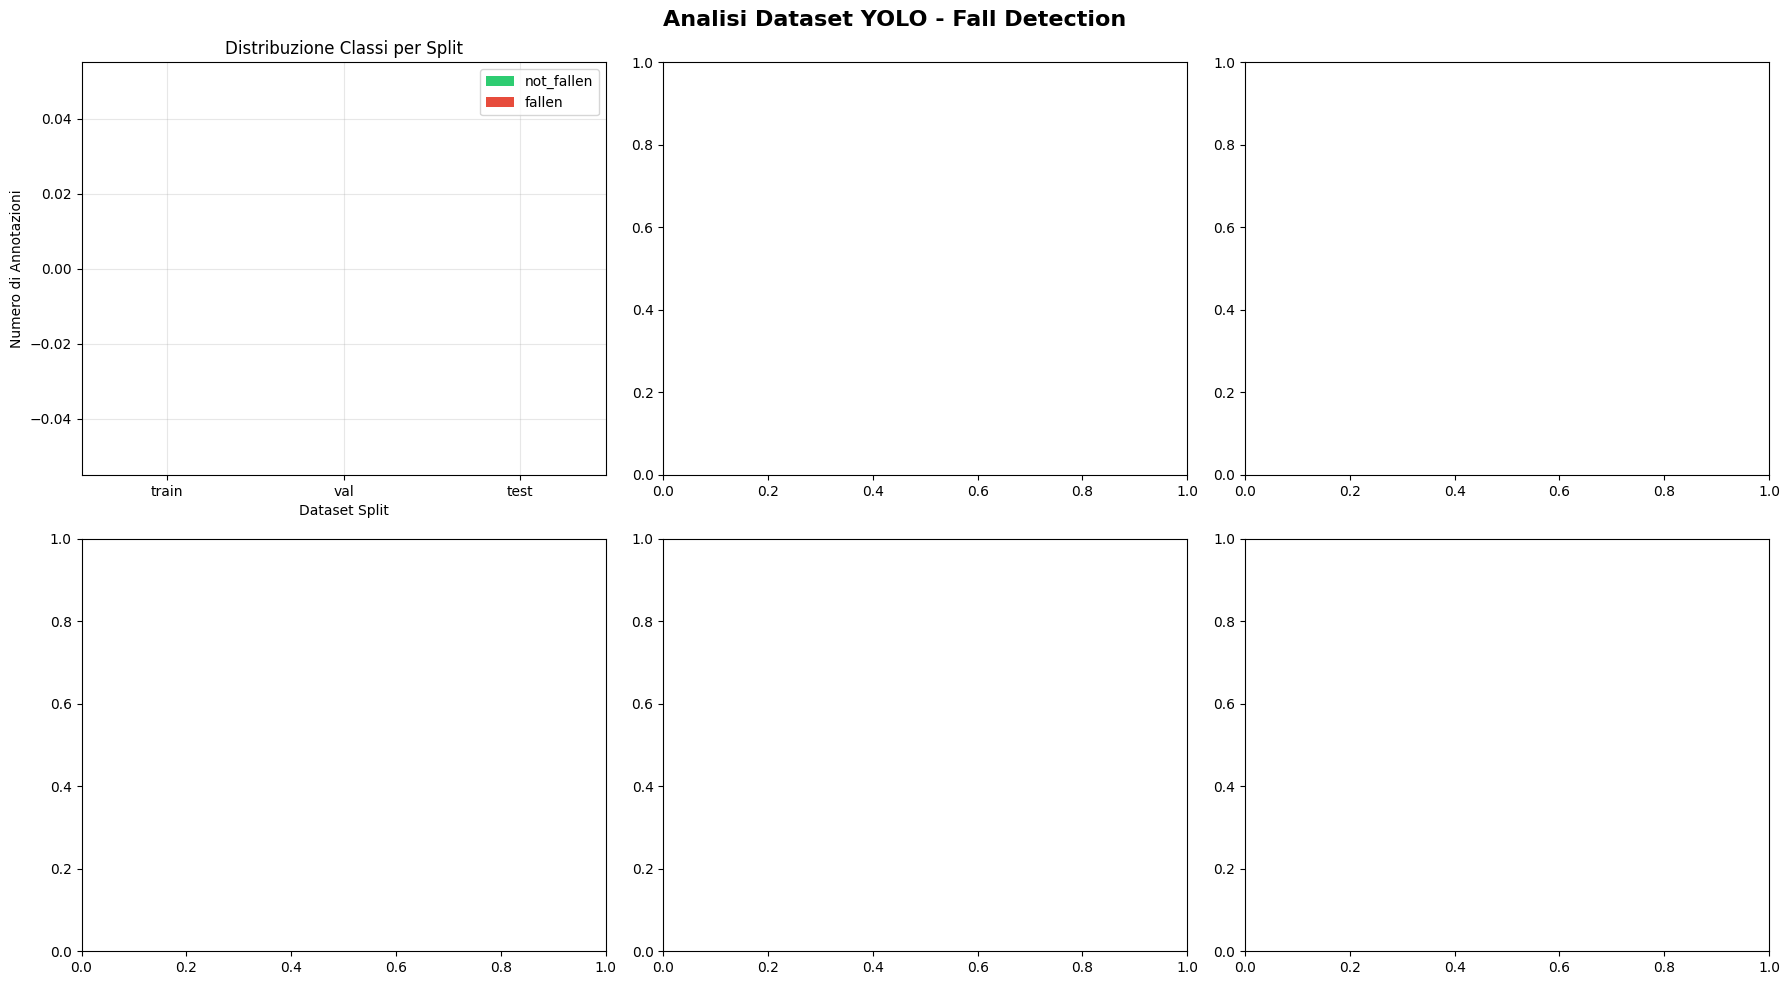

({'train': {0: 0, 1: 0}, 'val': {0: 0, 1: 0}, 'test': {0: 0, 1: 0}},
 {'widths': [], 'heights': [], 'areas': [], 'aspects': []})

In [18]:
print("\n🔍 FASE 1: Analisi Dataset")
trainer.analyze_dataset()

In [ ]:
print("\n🔄 FASE 2: Data Augmentation")
response = input("\nVuoi creare un dataset augmentato? (s/n): ")
if response.lower() == 's':
    trainer.create_augmented_dataset(augmentation_factor=3)

In [ ]:
print("\n🚀 FASE 3: Training")
response = input("\nVuoi avviare il training? (s/n): ")
if response.lower() == 's':
model, results, metrics = trainer.train_model(
    epochs=100,  # Riduci se vuoi test più veloci
    patience=20,
    batch_size=16  # Riduci se hai poca RAM
)

In [ ]:
print("\n📊 FASE 4: Test e Valutazione")
if os.path.exists('best_fall_detection_yolo11.pt'):
    trainer.test_model()
    trainer.create_confusion_matrix_advanced()

In [ ]:
print("\n🖼️ FASE 5: Test Predizione")
test_image = input("\nInserisci il path di un'immagine di test (o premi Enter per saltare): ")
if test_image and os.path.exists(test_image):
    trainer.predict_image(test_image)